# <h1 align = 'center'>Simulating TTV</h1>
<p align = 'center'> K M Shariat Ullah </p>

This notebook deals with TTVs of exoplanets by first giving an intuition of what TTVs are and then by simulating solar system's three planets orbit to show the TTV of the innermost planet. For simulation, it uses [Rebound](https://rebound.readthedocs.io/), an open source software.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
from scipy.optimize import curve_fit

### O-C Curve

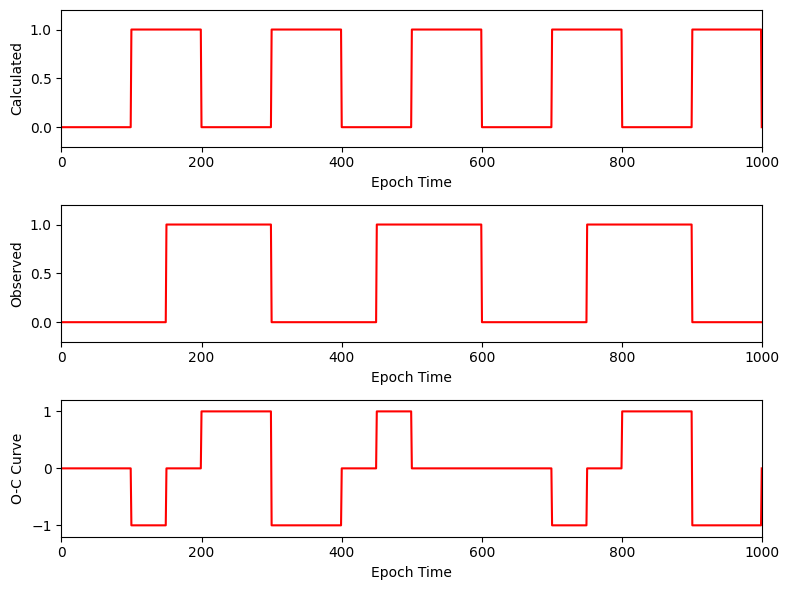

In [51]:
def square(P):
  t = np.linspace(0,10, 1000)
  amp = np.where(t % P <= P/2, 0, 1)
  return amp

t = np.linspace(0,10, 1000)

titles = ['Calculated', 'Observed', 'O-C Curve']
data = [square(2), square(3), square(3) - square(2)]

plt.figure(figsize=(8, 6))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.xlabel('Epoch Time')
    plt.ylabel(titles[i])
    plt.xlim(0, 1000)
    plt.ylim(-1.2 if i == 2 else -0.2, 1.2)
    plt.plot(data[i], color= 'red')

plt.tight_layout()
plt.show()

### Simulation Setup

In [52]:
sim = rebound.Simulation()
sim.units = ("AU", "yr", "Msun")

# star
sim.add(m=1.0)

# planets
sim.add(m=3e-6, a=1, e=0.0167)                # earth
sim.add(m = 3.227e-7, a= 1.524, e = 0.0934)   # mars
sim.add(m=9.5e-4, a=5.2, e=0.0489)            # jupiter

# parameters
sim.integrator = "ias15"                      # High-accuracy integrator
sim.dt = 0.01                                 # Time step in years
sim.move_to_com()                             # Move to center-of-mass frame

### Simulation

In [53]:
def find_transits(sim, planet_index, tmax=10, dt=0.001):
    times = []
    t = 0
    while t < tmax:
        sim.integrate(t)
        x = sim.particles[planet_index].x
        vx = sim.particles[planet_index].vx
        if x > 0 and vx < 0:  # Check for x = 0 crossing with negative velocity
            times.append(t)
        t += dt
    return np.array(times)

### O - C curve for Earth

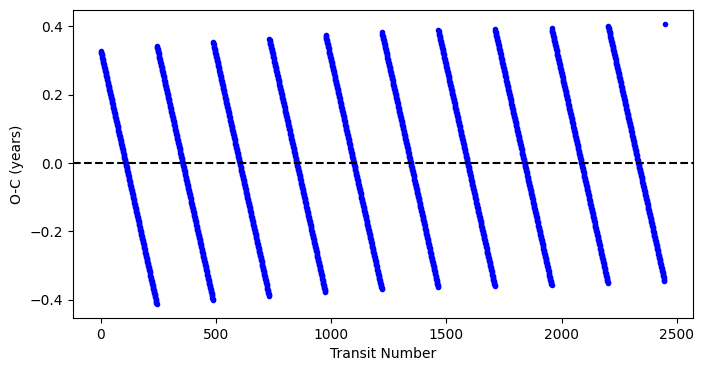

In [54]:
transit_times = find_transits(sim, planet_index=1, tmax=10)

# Fit a linear ephemeris (expected transit times)
def linear_model(n, P, T0):
    return T0 + P * n

n_values = np.arange(len(transit_times))
params, _ = curve_fit(linear_model, n_values, transit_times)
P_fit, T0_fit = params
expected_transits = linear_model(n_values, P_fit, T0_fit)

# Compute O-C values
O_minus_C = transit_times - expected_transits
plt.figure(figsize=(8, 4))
plt.scatter(n_values, O_minus_C, color='b', marker='.', label='O-C Residuals')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Transit Number")
plt.ylabel("O-C (years)")
plt.show()

### Orbits

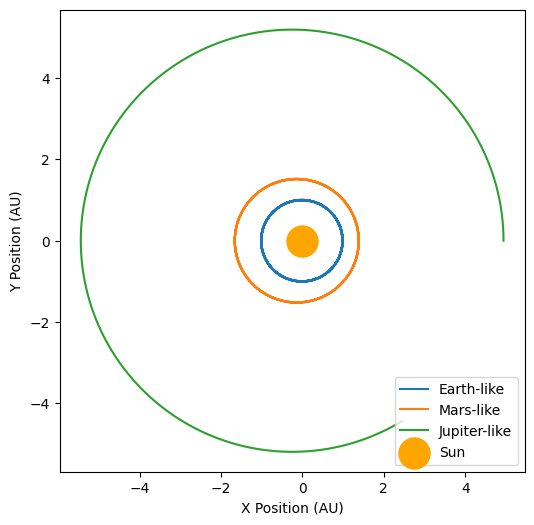

In [55]:
sim.integrate(0)  # Reset the simulation for orbit visualization
positions = {"planet1": [], "planet2": [], "planet3": []}
times = np.linspace(0, 10, 1000)
for t in times:
    sim.integrate(t)
    positions["planet1"].append((sim.particles[1].x, sim.particles[1].y))
    positions["planet2"].append((sim.particles[2].x, sim.particles[2].y))
    positions["planet3"].append((sim.particles[3].x, sim.particles[3].y))

positions["planet1"] = np.array(positions["planet1"])
positions["planet2"] = np.array(positions["planet2"])
positions["planet3"] = np.array(positions["planet3"])

plt.figure(figsize=(6, 6))
plt.plot(positions["planet1"][:, 0], positions["planet1"][:, 1], label="Earth-like")
plt.plot(positions["planet2"][:, 0], positions["planet2"][:, 1], label="Mars-like")
plt.plot(positions["planet3"][:, 0], positions["planet3"][:, 1], label="Jupiter-like")
plt.scatter(0, 0, color='#FFA500', s = 500, label="Sun")
plt.xlabel("X Position (AU)")
plt.ylabel("Y Position (AU)")
plt.legend()
plt.axis("equal")
plt.show()